# Project Team: Walking in Paris

Objective:
---------------
Identify the attributes that make Airbnb “Successful" in Hawaii

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

# Import statistic library
import scipy.stats as stats
from scipy.stats import linregress

# Import seaborn library to create figure
import seaborn as sns

import pprint
import json
from time import sleep
from datetime import date
import zipfile

# Incorporated citipy to determine city based on latitude and longitude
# pip install citipy
from citipy import citipy

# added modules by lance
import gmaps
import os
import scipy.stats as stats
from api_keys import g_key
gmaps.configure(api_key=g_key)

# Output File location
output_folder = "output_data"

In [76]:
# This code will suprese the warning on the code
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=RuntimeWarning)

OPEN THE FILE
-----------------------
Open the dataset from the zip file and ensure memory resources

In [36]:
# Open the zip file
zf = zipfile.ZipFile('./source_data/detail_listings.zip') 
df = pd.read_csv(zf.open('detail_listings.csv'), low_memory=False)

rows_in_df = len(df)
print(f'Data set has {rows_in_df} rows')
df.head(1)

Data set has 23745 rows


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5065,https://www.airbnb.com/rooms/5065,20191204162636,2019-12-04,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,...,f,f,moderate,f,f,2,2,0,0,0.45


DATA PREPARATION 1:
----------------------------------
Organize the columns to make the analysis easy

In [4]:
# Group the columns and show the list of the columns

print('')
print('----------------------')
print('Property-specific columns:')
print('----------------------')

# Create a wildcard to search the terms
cols = ["experiences_offered", "street", "city", "state", "zipcode", "market", "country", "property"
    , "location", "accomodate", "room", "guest", "is_business_travel_ready", "instant_bookable", "cancel"]

# Lopps the columns
for col in df.columns: 
    if col in cols:
        print(col) 
        
print('')
print('----------------------')
print('All columns:')
print('----------------------')
for col in df.columns: 
    print(col)


----------------------
Property-specific columns:
----------------------
experiences_offered
street
city
state
zipcode
market
country
instant_bookable
is_business_travel_ready

----------------------
All columns:
----------------------
id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities

DATA PREPARATION 2:
----------------------------------
Created separate data frame to allow us to “group” columns (Property-related, Neighborhood-related, etc)

In [5]:
# Create a dataframe with one (1) row for each column in the source data:
data_dict = pd.DataFrame(columns = [
    "ColumNumber"
    , "Column"
    , "Group"
    , "Subgroup"
    , "Notes"
])

# Loop through the columns in the data frame
for column in df:
    data_dict = data_dict.append({
            "Column": column
            , "Group": ""
            , "Subgroup": ""
            , "Notes": ""
        }
        , ignore_index=True
    )

# Make the index the column number
data_dict['ColumNumber'] = data_dict.index
        
# Add context for each column 
for index, row in data_dict.iterrows():
    val = str(row["Column"])
    
    if val == "id":
        data_dict.loc[index, "Notes"] = "Primary Key"
    # Val.startswith("host_")  
    if val.find("host") > -1: 
        data_dict.loc[index, "Group"] = "Host-related"
    
    if val.find("review") > -1:
        data_dict.loc[index, "Group"] = "Review-related"
        
    if (val.find("rule") > -1) | (val.find("require") > -1):
        data_dict.loc[index, "Group"] = "Requirements-related"
        
    if (val.find("neighbo") > -1):
        data_dict.loc[index, "Group"] = "Neighborhood-related"
        
    if (val.find("nights") > -1):
        data_dict.loc[index, "Group"] = "Booking-related"
        
    # Property specific:
    cols = [
        "property", "room", "guest", "is_business_travel_ready", "instant_bookable", "cancel",
        "space", "name", "summary", "description", "notes", "transit", "access", "interaction",
        "property_type", "room_type", "amenities"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        
    # Property - "Location" specific:
    cols = [
        "location", "street", "city", "state", "zipcode", "market", "country"
        , "latitude", "longitude", "is_location_exact"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Location"
        
    # Property - "Interior" specific:
    cols = [
        "bathrooms", "bedrooms", "beds", "square_feet"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Interior"
        
    # Property - "Pricing" specific:
    # Variables related to price, or that we might associate with price
    cols = [
        "price", "weekly_price", "monthly_price"        
        , "security_deposit", "cleaning_fee"
        , "accomodates", "guests_included", "extra_people"
        , "experiences_offered"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Pricing"
        
    # Accomodate a group and subgroup of properties:
    if val == "accommodates":
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Pricing"

print(data_dict.groupby(["Group", "Subgroup"])["Column"].count())
print('')
print('Columns without a group:')
data_dict[data_dict["Group"] == ""]

Group                 Subgroup
                                  17
Booking-related                    8
Host-related                      17
Neighborhood-related               5
Property-related                  20
                      Interior     4
                      Location    13
                      Pricing      9
Requirements-related               2
Review-related                    11
Name: Column, dtype: int64

Columns without a group:


,ColumNumber,Column,Group,Subgroup,Notes
0,0,id,,,Primary Key
1,1,listing_url,,,
2,2,scrape_id,,,
3,3,last_scraped,,,
15,15,thumbnail_url,,,
16,16,medium_url,,,
17,17,picture_url,,,
18,18,xl_picture_url,,,
57,57,bed_type,,,
75,75,calendar_updated,,,


DATA PREPARATION 3:
----------------------------------
- Create a group by neighbourhood and number of reviews

In [7]:
# data_dict[data_dict["Group"] == "Host-related"]
host_group = df.groupby("neighbourhood").agg({
    "number_of_reviews": [
        np.count_nonzero,
        np.mean, 
        np.median, 
        np.var, 
        np.std
    ]
})

host_group.rename(columns={'count_nonzero':'Reviews'})
host_group.head()

number_of_reviews                    \
                                      count_nonzero       mean median   
neighbourhood                                                           
Aiea                                             14  33.294118    7.0   
Airport                                           3   4.000000    4.0   
Ala Moana/Kakaako                                28  13.829787    1.0   
Aliamanu/Salt Lake/Foster Village                 8  74.875000    9.5   
Central Oahu                                     43  27.391304   14.5   

                                                             
                                            var         std  
neighbourhood                                                
Aiea                                2586.220588   50.854897  
Airport                                9.000000    3.000000  
Ala Moana/Kakaako                    801.013876   28.302189  
Aliamanu/Salt Lake/Foster Village  17739.267857  133.188843  
Central Oahu                        1186.643478   34.447692

DATA PREPARATION 4:
----------------------------------
- Create bin to separate by the number of reviews

In [34]:
# bin on reviews_per_month
bins_num_reviews = [10, 20, 50, 100, 200, 300, 350, 400, 450, 500, 550, 600, 100000]

# labels - always one less than the range
group_names_num_reviews = [
    "1-10"
    , "11-20"
    , "21-50"
    , "100-200"
    , "201-250"
    , "251-300"
    , "301-350"
    , "351-400"
    , "401-550"
    , "451-500"
    , "501-550"
    , "551-600"
]

df["Bin_NumReviews"] = pd.cut(
    df["number_of_reviews"], 
    bins = bins_num_reviews, 
    labels = group_names_num_reviews
)

df["Bin_NumReviews"].value_counts()

11-20      3790
1-10       2526
21-50      2368
100-200    1235
201-250     250
251-300      32
301-350      23
351-400      10
401-550       6
551-600       3
451-500       3
501-550       1
Name: Bin_NumReviews, dtype: int64

In [9]:
# print the number of reviews
print(f'Sum: {df["number_of_reviews"].sum()}')
print(f'Count: {df["number_of_reviews"].count()}')

df.groupby("Bin_NumReviews")["number_of_reviews"].sum()

Sum: 623494
Count: 23745


Bin_NumReviews
1-10        37991
11-20      126389
21-50      169320
100-200    169224
201-250     59598
251-300     10221
301-350      8452
351-400      4217
401-550      2864
451-500      1561
501-550       569
551-600      1983
Name: number_of_reviews, dtype: int64

In [10]:
# Aggregate the group by numebr of reviews
df.groupby("Bin_NumReviews").agg({
    "number_of_reviews": [
        np.count_nonzero,
        np.mean, 
        np.median, 
        np.var, 
        np.std
    ]
})

number_of_reviews                                          
                   count_nonzero        mean median         var        std
Bin_NumReviews                                                            
1-10                        2526   15.039984   15.0    8.161173   2.856777
11-20                       3790   33.348021   32.0   74.548947   8.634173
21-50                       2368   71.503378   70.0  197.305439  14.046545
100-200                     1235  137.023482  131.0  741.095883  27.223076
201-250                      250  238.392000  232.0  802.456161  28.327657
251-300                       32  319.406250  318.0  176.958669  13.302581
301-350                       23  367.478261  366.0  157.988142  12.569333
351-400                       10  421.700000  421.5  252.900000  15.902830
401-550                        6  477.333333  485.5  246.666667  15.705625
451-500                        3  520.333333  518.0   24.333333   4.932883
501-550                        1  569.000000  569.0         NaN        NaN
551-600                        3  661.000000  669.0  577.000000  24.020824

We analyze some hypothesis during the data preparation.

Hypothesis candidates

Neighborhood
- Is rating related to price within a neighborhood? 
- The highest price properties in a neighboorhood will have lower ratings than the lowest price properties?
- Best neighborhoods by rating
- Best neighborhoods by price
- Listing types by neighborhood
- Listing types by price
- Listing types by rating

By island: 
- Is one island more expensive than the others?

DATA VALIDATION 1:
------------------------------
Create a figures to visualize the data behauvior 

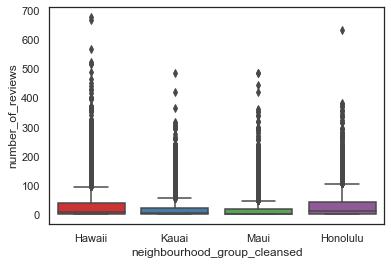

In [14]:
# Use seaborn library to create a boxplot
# sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")
sns.boxplot(
    x = "neighbourhood_group_cleansed",
    y = "number_of_reviews",
    data = df,
    palette = "Set1"
)

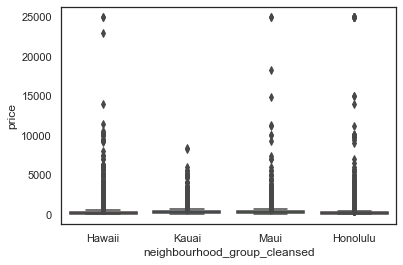

In [38]:
import seaborn as sns
#sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")
sns.boxplot(
    x = "neighbourhood_group_cleansed",
    y = "price",
    data = df,
    palette = "Set1"
)

In [39]:
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

,ColumNumber,Column,Group,Subgroup,Notes
8,8,experiences_offered,Property-related,Pricing,
53,53,accommodates,Property-related,Pricing,
60,60,price,Property-related,Pricing,
61,61,weekly_price,Property-related,Pricing,
62,62,monthly_price,Property-related,Pricing,
63,63,security_deposit,Property-related,Pricing,
64,64,cleaning_fee,Property-related,Pricing,
65,65,guests_included,Property-related,Pricing,
66,66,extra_people,Property-related,Pricing,


In [40]:
# If a host has a hugh number of properties then their ratings are not higher than 
# hosts with fewer properties
bins = [1, 60, 119, 179, 239, 299]

# labels - always one less than the range
group_names = ["0-59 properties", "60-119 properties", "120-179 properties", "180-239 properties", "240+ properties"]

df["Bin_NumProperties"] = pd.cut(df["host_total_listings_count"], bins, labels=group_names)

# df_analyze = pd.concat([df["host_id"], df["host_total_listings_count"], df["Bin_NumProperties"]]).unique()
df_analyze = df.groupby(["host_id", "host_total_listings_count"])
df_analyze.head()

df.groupby(["host_id", "host_total_listings_count"]).count()
# Hosts that have host_total_listings_count == 0

any_dupe_listings = df.groupby(["host_id"]).agg({
        # number of unique listings
        'host_total_listings_count': "nunique"
    }
)

# Are there any where the listing count is wrong?
any_dupe_listings[any_dupe_listings["host_total_listings_count"] > 1]
print("No - no bad data")

No - no bad data


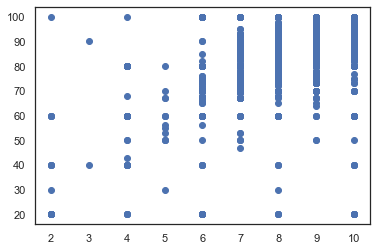

In [41]:
# Drop all values outside the normal distribution:
x_values = df["review_scores_cleanliness"]
y_values = df["review_scores_rating"]
plt.scatter(x_values, y_values)

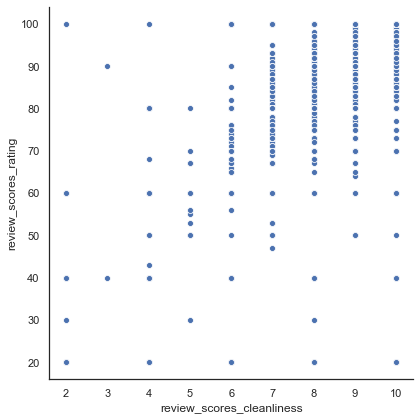

In [12]:
# Use seaborn library to create a relplot
sns.set(style="white")

x_values = df["review_scores_cleanliness"]
y_values = df["review_scores_rating"]

sns.relplot(
    x="review_scores_cleanliness", 
    y="review_scores_rating", 
    #hue="origin", 
    #size="weight",
    #sizes=(40, 400), 
    #alpha=.5, 
    palette="muted",
    height=6, 
    data=df
)

Use the function catplot to show the relationship between a numerical and one or more categorical variables using one of several visual representation. 

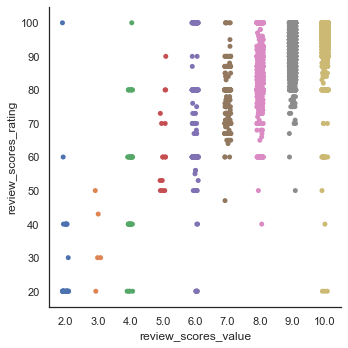

In [42]:
# Potential question: Of the six dimensions for ratings (Accuracy, Cleanliness, Checkin, Communication, Location, Value), 
# is one more important than the rest? 
# Example: if a property is a low Cleanliness score, would it be more likely that all other scores 
# are also lower on average?

sns.catplot(
    x="review_scores_value", 
    y="review_scores_rating", 
    data=df
);

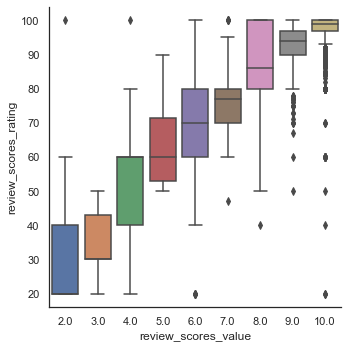

In [43]:
sns.catplot(
    x="review_scores_value", 
    y="review_scores_rating", 
    data=df,
    kind="box"
);

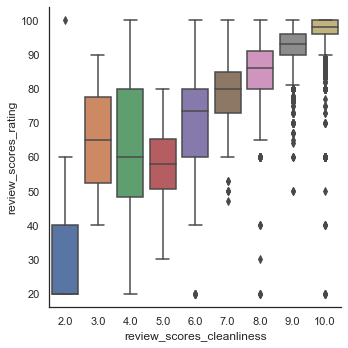

In [44]:
sns.catplot(
    x="review_scores_cleanliness", 
    y="review_scores_rating", 
    data=df,
    kind="box"
);

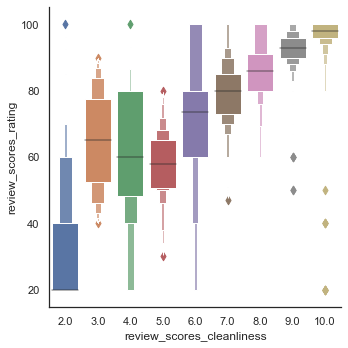

In [45]:
sns.catplot(
    x="review_scores_cleanliness", 
    y="review_scores_rating", 
    kind="boxen",
    data = df.sort_values("price")
)

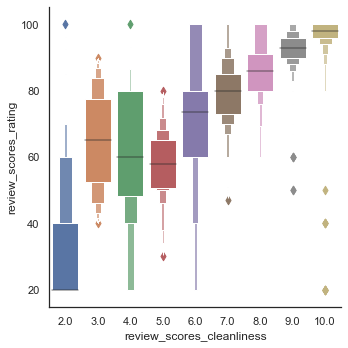

In [46]:
sns.catplot(
    x="review_scores_cleanliness", 
    y="review_scores_rating", 
    kind="boxen",
    data=df
)

DATA VALIDATION 2:
------------------------------
Evaluate dataset to identify variables that are correlated

We are using the heatmap to represent the data in a 2-dimensional form and obtain
a colored visual summary of information.

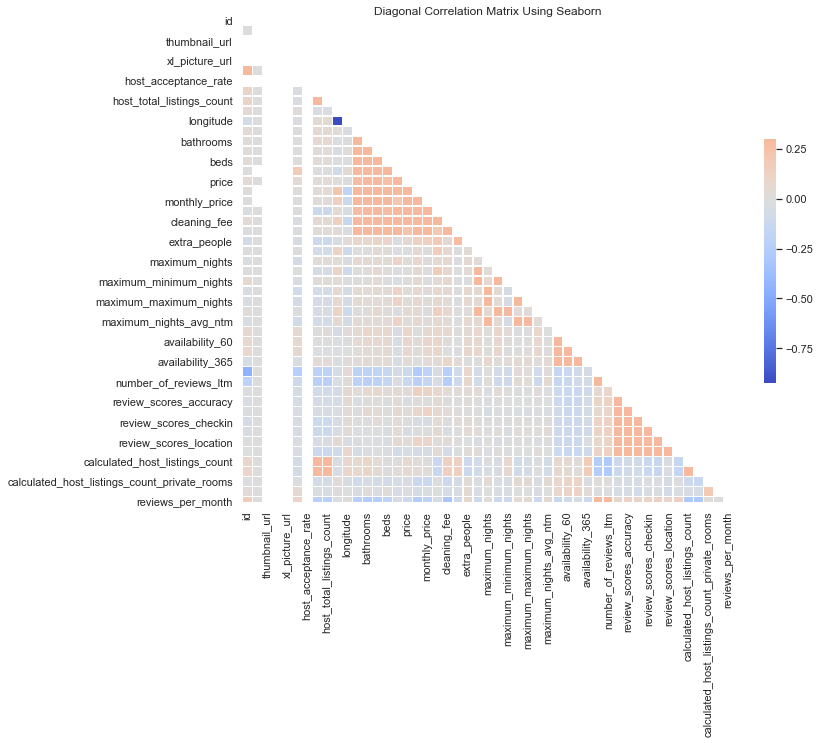

In [51]:
# Create data frame correlation
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap='coolwarm'

# Labels
ax.set_title('Diagonal Correlation Matrix Using Seaborn')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=.3, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
).get_figure().savefig('correlation_matrix.png') # Save to a file

plt.show()

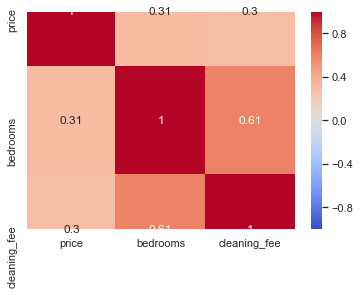

In [52]:
sns.heatmap(
    df[["price", "bedrooms", "cleaning_fee", "neighbourhood_group_cleansed"]].corr(),
    vmin=-1,
    vmax=1,
    cmap='coolwarm',
    annot=True
);

CLEANING THE DATA 1:
----------------------------------
Cleaning raw data to delete the column with not values, columns values duplicated, columns with data not required.

In [28]:
# Drop unneeded columns:
df = df.drop(columns = [
    "listing_url", 
    "thumbnail_url", 
    "picture_url",    
    "medium_url",    
    "xl_picture_url", 
    "host_url",       
    "host_thumbnail_url", 
    "host_picture_url",  
    "scrape_id",   
    "host_listings_count", 
    "host_acceptance_rate", 
    "calendar_last_scraped",
    "bed_type",
    "last_scraped",
    "calendar_updated",
    "has_availability",
    "availability_30", 
    "availability_60", 
    "availability_90", 
    "license"
])

df.head(1)

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Bin_NumProperties,Bin_NumReviews
0,5065,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,Located near by is Kalopa State Park with 100 ...,There is a bus stop located in Honoka'a town ...,A BBQ grill is available,...,moderate,f,f,2,2,0,0,0.45,0-50 properties,11-20


CLEANING THE DATA 2:
----------------------------------
- Get names of indexes for which column number_of_reviews has value 0 and droppping the rows.

In [29]:
# Drop by index:
indexNames = df[df['number_of_reviews'] == 0 ].index
df.drop(indexNames , inplace=True)

# Drop rows with number_of_reviews = NaN
df.dropna(axis=0, subset=('number_of_reviews', ))

# Drop rows with NaN review data
df.dropna(axis=0, subset=(
    'review_scores_rating', 
    'review_scores_accuracy', 
    'review_scores_cleanliness', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_location', 
    'review_scores_value'
))

print(f'Remaining rows after cleanup: {len(df)}')


Remaining rows after cleanup: 18291


CLEANING THE DATA 3:
-----------------------------------------------------------
- Remove the dollar symbol ($) from the pricing  based columns:
"price", "weekly_price","monthly_price","security_deposit","cleaning_fee", "extra_people"  

In [37]:
# Strip the $ out of the pricing-based columns
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

if df["price"].dtype != "float64":
    df["price"] = df["price"].str.replace("$", "")
    df["price"] = df["price"].str.replace(",", "")
    df["price"] = df["price"].astype("float64")

if df["weekly_price"].dtype != "float64":
    df["weekly_price"] = df["weekly_price"].str.replace("$", "")
    df["weekly_price"] = df["weekly_price"].str.replace(",", "")
    df["weekly_price"] = df["weekly_price"].astype("float64")

if df["monthly_price"].dtype != "float64":
    df["monthly_price"] = df["monthly_price"].str.replace("$", "")
    df["monthly_price"] = df["monthly_price"].str.replace(",", "")
    df["monthly_price"] = df["monthly_price"].astype("float64")
    
if df["security_deposit"].dtype != "float64":
    df["security_deposit"] = df["security_deposit"].str.replace("$", "")
    df["security_deposit"] = df["security_deposit"].str.replace(",", "")
    df["security_deposit"] = df["security_deposit"].astype("float64")
    
if df["cleaning_fee"].dtype != "float64":
    df["cleaning_fee"] = df["cleaning_fee"].str.replace("$", "")
    df["cleaning_fee"] = df["cleaning_fee"].str.replace(",", "")
    df["cleaning_fee"] = df["cleaning_fee"].astype("float64")   

if df["extra_people"].dtype != "float64":
    df["extra_people"] = df["extra_people"].str.replace("$", "")
    df["extra_people"] = df["extra_people"].str.replace(",", "")
    df["extra_people"] = df["extra_people"].astype("float64")
    
# Show certain groups
df.loc[:,data_dict[data_dict["Group"] == "Host-related"]["Column"]]

,host_id,host_url,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes
0,7257,https://www.airbnb.com/users/show/7257,2009-01-31,HI\r\nWE LIVE HERE IN HONOKAA ON \r\nFARM JUS...,within a day,100%,NaN,f,https://a0.muscache.com/im/users/7257/profile_...,https://a0.muscache.com/im/users/7257/profile_...,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,f,2,2
1,7620,https://www.airbnb.com/users/show/7620,2009-02-09,"Lea, born and raised on the Island of Hawaii, ...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/16ac6...,https://a0.muscache.com/im/pictures/user/16ac6...,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,f,5,4
2,7878,https://www.airbnb.com/users/show/7878,2009-02-13,"Kona Hawaii,\r\n \r\n Ed is a Farmer/Designer ...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/b895b...,https://a0.muscache.com/im/pictures/user/b895b...,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,3,3
3,7878,https://www.airbnb.com/users/show/7878,2009-02-13,"Kona Hawaii,\r\n \r\n Ed is a Farmer/Designer ...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/b895b...,https://a0.muscache.com/im/pictures/user/b895b...,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,3,3
4,7887,https://www.airbnb.com/users/show/7887,2009-02-14,NaN,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/82631...,https://a0.muscache.com/im/pictures/user/82631...,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,f,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23740,18160832,https://www.airbnb.com/users/show/18160832,2014-07-15,"Aloha! I am the proud father of two children, ...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/10f45...,https://a0.muscache.com/im/pictures/user/10f45...,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,6,0
23741,298394653,https://www.airbnb.com/users/show/298394653,2019-09-27,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/1e6a9...,https://a0.muscache.com/im/pictures/user/1e6a9...,0.0,0.0,"['email', 'phone', 'offline_government_id', 'g...",t,f,3,3
23742,310747735,https://www.airbnb.com/users/show/310747735,2019-11-19,NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/2b0f1...,https://a0.muscache.com/im/pictures/user/2b0f1...,12.0,12.0,"['email', 'phone', 'offline_government_id', 'g...",t,f,12,3
23743,2677189,https://www.airbnb.com/users/show/2677189,2012-06-19,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/2677189/profi...,https://a0.muscache.com/im/users/2677189/profi...,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,1,1



HYPOTHESIS
-----------------------------------

Ho:
 There are certain factors that have an impact on the overall rating of an Air BNB property.
 
H1:
 None of the factors that we are analyzing have any impact on the overall rating of a property.


ANALYSIS OF THE DATA
-----------------------------------

Evaluate the relationship between "how many properties someone has" and review_scores_rating
-----------------------------------------------------------------------------------------------------------------

In [53]:
# Define the bins by number of properties by host
bins = [0, 50, 100, 150, 200, 250, 299]

# labels - always one less than the range
group_names = ["0-50 properties", "51-100 properties", "101-150 properties", "151-200 properties",\
               "201-250 properties", "251+ properties"]

df["Bin_NumProperties"] = pd.cut(df["calculated_host_listings_count"], bins, labels=group_names)

rating_mean_by_bin = df.groupby("Bin_NumProperties").mean()["review_scores_rating"]

df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Bin_NumProperties
0,5065,https://www.airbnb.com/rooms/5065,20191204162636,2019-12-04,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,...,f,moderate,f,f,2,2,0,0,0.45,0-50 properties
1,5269,https://www.airbnb.com/rooms/5269,20191204162636,2019-12-05,Upcountry Hospitality in the 'Auwai Suite,"The 'Auwai Suite is a lovely, self-contained a...","The ‘Auwai Suite is a lovely, self-contained a...","The 'Auwai Suite is a lovely, self-contained a...",none,"We are located on the ""sunny side"" of Waimea, ...",...,f,strict_14_with_grace_period,f,f,5,4,1,0,0.09,0-50 properties


<function matplotlib.pyplot.show(*args, **kw)>

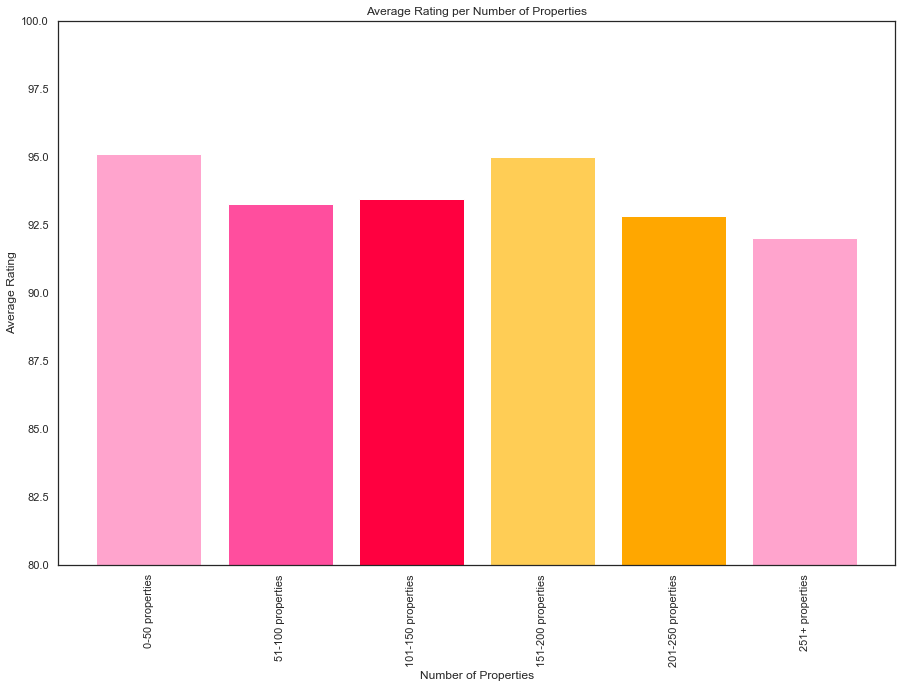

In [54]:
# Define the axis
x_axis = group_names
y_axis = rating_mean_by_bin

# Bring in the colors from Hawaii
hawaiian_hibiscus_hex_palette = ["#ffa4cd", "#ff4e9e", "#ff0040", "#ffcd55", "#ffa700"]

#Define the properties of the figure
plt.subplots(figsize=(15,10))
plt.title("Average Rating per Number of Properties")
plt.xlabel("Number of Properties")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(80, 100)
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)

#Show the figure
plt.show

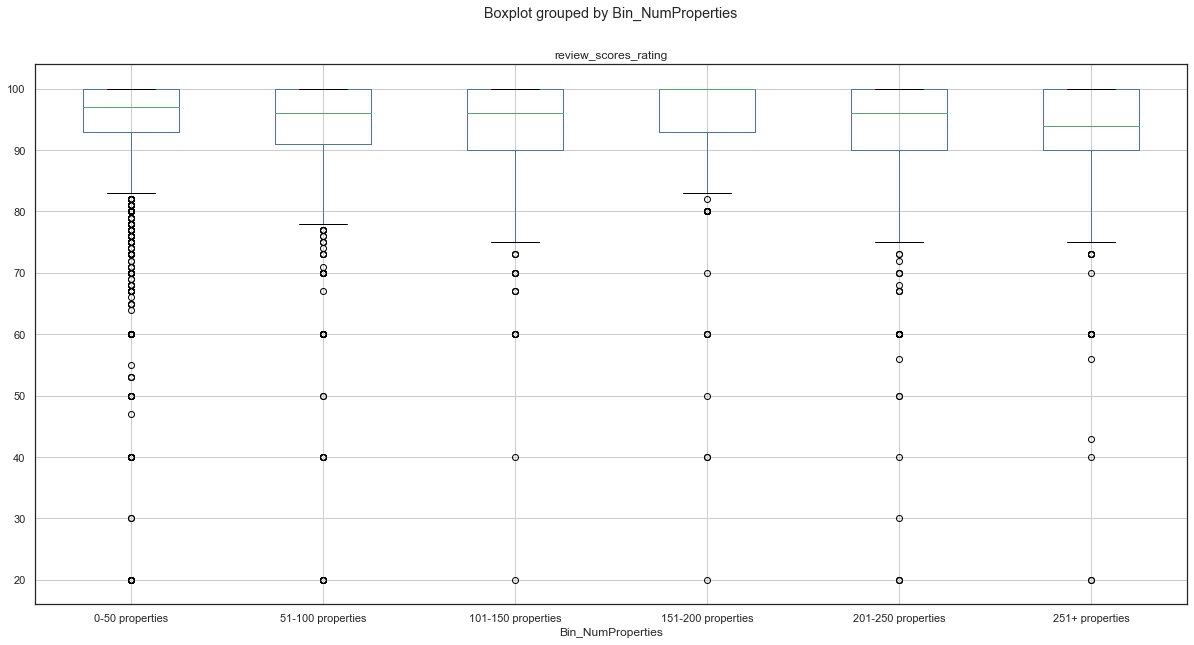

In [55]:
df.boxplot("review_scores_rating", by="Bin_NumProperties", figsize=(20, 10))

In [56]:
# Extract individual groups
group1 = df[df["Bin_NumProperties"] == "0-50 properties"]["review_scores_rating"].dropna()
group2 = df[df["Bin_NumProperties"] == "51-100 properties"]["review_scores_rating"].dropna()
group3 = df[df["Bin_NumProperties"] == "101-150 properties"]["review_scores_rating"].dropna()
group4 = df[df["Bin_NumProperties"] == "151-200 properties"]["review_scores_rating"].dropna()
group5 = df[df["Bin_NumProperties"] == "201-250 properties"]["review_scores_rating"].dropna()
group6 = df[df["Bin_NumProperties"] == "251+ properties"]["review_scores_rating"].dropna()

stats.f_oneway(group1, group2, group3, group4, group5, group6)

F_onewayResult(statistic=43.11618122403286, pvalue=2.439976302263326e-44)

Evaluate the relationship between "neighbourhood" and review_scores_rating
-------------------------------------------------------------------------------------------------

<function matplotlib.pyplot.show(*args, **kw)>

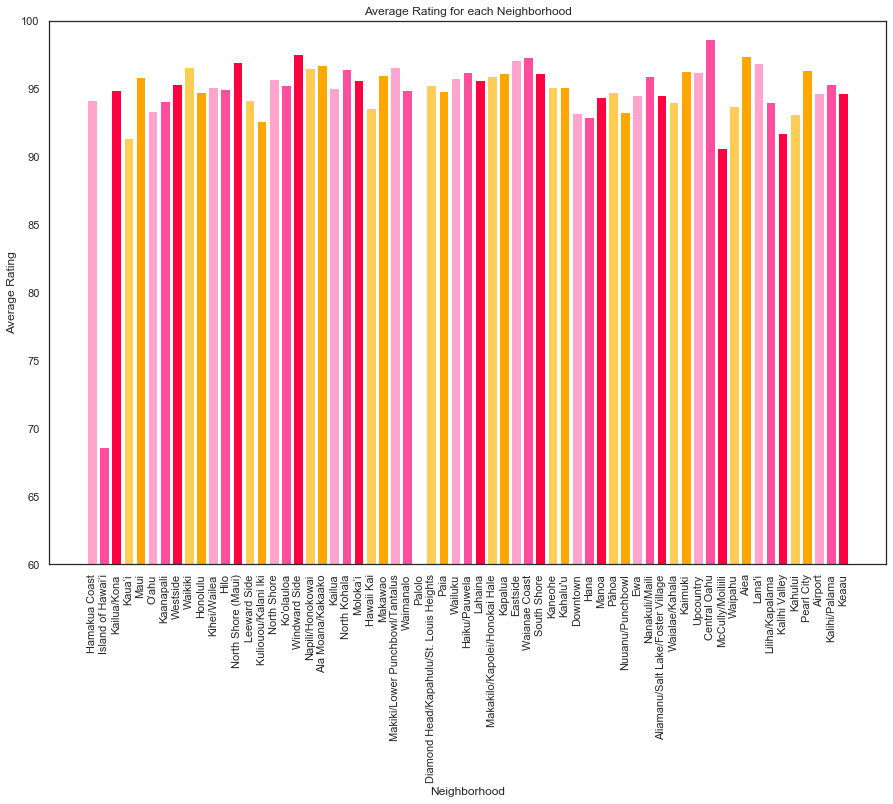

In [57]:
neighborhood_list = df["neighbourhood"].unique()

average_rating_per_neighborhood = df.groupby("neighbourhood").mean()["review_scores_rating"]
average_rating_per_neighborhood.sort_values(ascending=True)


cleaned_neighborhood_list = [x for x in neighborhood_list if str(x) != 'nan']
cleaned_neighborhood_list

x_axis = cleaned_neighborhood_list
y_axis = average_rating_per_neighborhood

hawaiian_hibiscus_hex_palette = ["#ffa4cd", "#ff4e9e", "#ff0040", "#ffcd55", "#ffa700"]

plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
plt.title("Average Rating for each Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Average Rating")
plt.ylim(60, 100)
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette, align='center')
plt.show

Evaluate the relationship between "price" and review_scores_rating
-------------------------------------------------------------------------------------------------

Observations:

The r-squared is: 0.01878917756905458


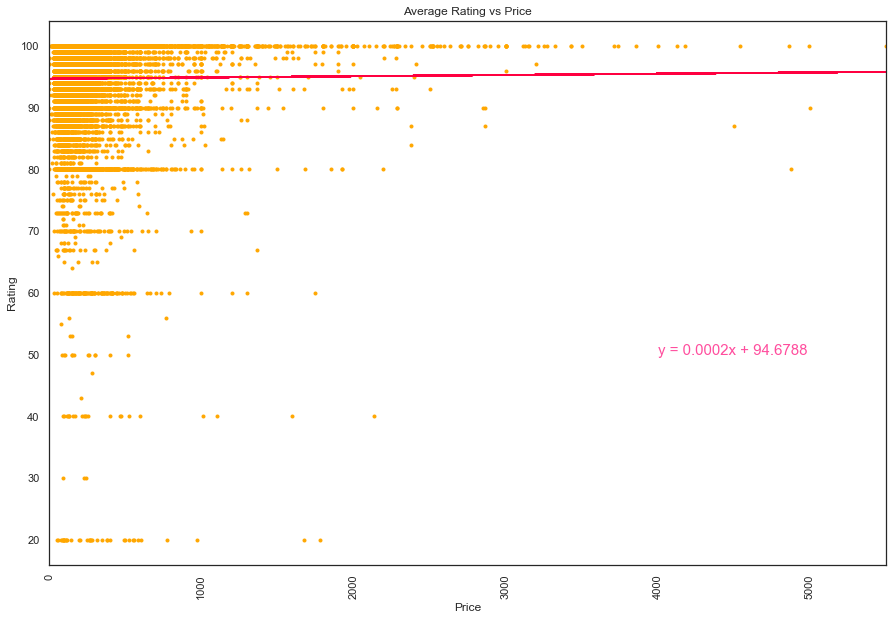

In [58]:
# Define axis
x_axis = df["price"]
y_axis = df["review_scores_rating"]


mask = ~np.isnan(x_axis) & ~np.isnan(y_axis)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis[mask], y_axis[mask])
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,4))

plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
plt.xlim(0, 5500)
plt.plot(x_axis,regress_values,"r-", color = "#ff0040")
plt.scatter(x_axis,y_axis, marker=".", color="#ffa700")
plt.annotate(line_eq,(4000,50),fontsize=15,color="#ff4e9e")
plt.title("Average Rating vs Price")
plt.xlabel('Price')
plt.ylabel('Rating')
print(f"The r-squared is: {r_value}")
plt.show()

Evaluate the relationship between "number of bedrooms" and review_scores_rating.
-------------------------------------------------------------------------------------------------------------------------

Create a new data frane (df2) so it didn't interfere with the data frame df

In [59]:
# create a dataframe with no 0's for 'number of beds' becuase that would be inaccurate data
df2 = df.copy()
df2 = df2[(df2['beds'] != 0)]

In [60]:
# zero beds is actually an option. A 'sofa bed' is not a real bed and is not counted as such.
bins = [0, 2, 4, 6, 8, 10, 12, 20]

group_names = ["1-2 beds", "3-4 beds", "5-6 beds", "7-8 beds", "9-10 beds", "11-12 beds", "13+ beds"]

df2["bin_bed_count"] = pd.cut(df2["beds"], bins, labels=group_names)

rating_mean_by_bed_count = df2.groupby("bin_bed_count").mean()["review_scores_rating"]

<function matplotlib.pyplot.show(*args, **kw)>

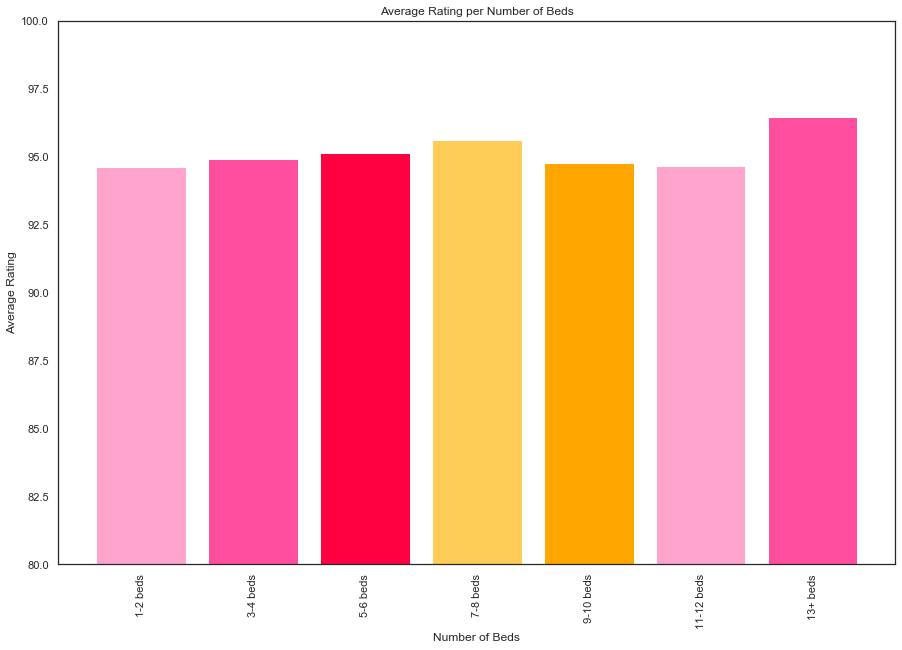

In [61]:
x_axis = group_names
y_axis = rating_mean_by_bed_count

hawaiian_hex_palette = ["#00739f", "#b23948", "#ff000e", "#ff407c", "#ffb2e1"]

plt.subplots(figsize=(15,10))
plt.title("Average Rating per Number of Beds")
plt.xlabel("Number of Beds")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(80, 100)
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)
plt.show

In [62]:
# Extract individual groups
group1 = df2[df2["bin_bed_count"] == "1-2 beds"]["review_scores_rating"].dropna()
group2 = df2[df2["bin_bed_count"] == "3-4 beds"]["review_scores_rating"].dropna()
group3 = df2[df2["bin_bed_count"] == "5-6 beds"]["review_scores_rating"].dropna()
group4 = df2[df2["bin_bed_count"] == "7-8 beds"]["review_scores_rating"].dropna()
group5 = df2[df2["bin_bed_count"] == "9-10 beds"]["review_scores_rating"].dropna()
group6 = df2[df2["bin_bed_count"] == "11-12 beds"]["review_scores_rating"].dropna()
group7 = df2[df2["bin_bed_count"] == "13+ beds"]["review_scores_rating"].dropna()

stats.f_oneway(group1, group2, group3, group4, group5, group6, group7)

F_onewayResult(statistic=1.9898838026156875, pvalue=0.06339752789743165)

Evaluate the relationship between "Island" and review_scores_rating
--------------------------------------------------------------------------------------------------

Observations:

### Comparison between average rating given for properties by Island

In [63]:
# grouping by columns needed and taking average of ratings per island
average_rating_island = df.groupby("neighbourhood_group_cleansed").mean()["review_scores_rating"].sort_values(ascending=False)
average_rating_island.head()

neighbourhood_group_cleansed
Hawaii      95.483893
Maui        95.160074
Kauai       94.907945
Honolulu    93.690300
Name: review_scores_rating, dtype: float64

In [64]:
average_rating_island = df.groupby("neighbourhood_group_cleansed").mean()["review_scores_rating"]
properties_island = df.groupby("neighbourhood_group_cleansed").count()["id"]
average_rating_island.head()

neighbourhood_group_cleansed
Hawaii      95.483893
Honolulu    93.690300
Kauai       94.907945
Maui        95.160074
Name: review_scores_rating, dtype: float64

In [65]:
# create variables and dataframe for desired data and ability to sort later
islands = df["neighbourhood_group_cleansed"].unique()
sorted_island_df = pd.DataFrame({"Average Rating": average_rating_island})

# reset index to reference column in graph
sorted_island_df = sorted_island_df.reset_index()
sorted_island_df

,neighbourhood_group_cleansed,Average Rating
0,Hawaii,95.483893
1,Honolulu,93.690300
2,Kauai,94.907945
3,Maui,95.160074


<function matplotlib.pyplot.show(*args, **kw)>

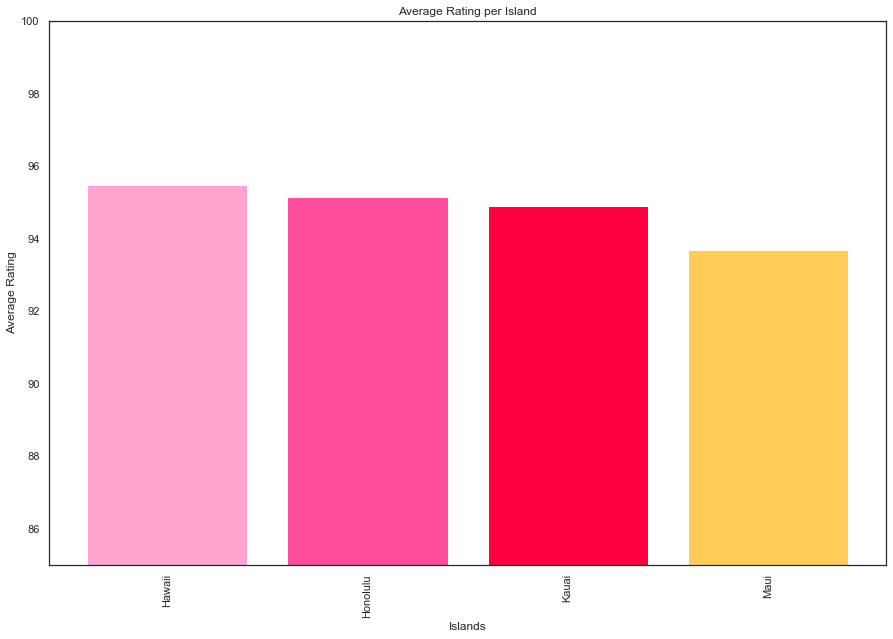

In [66]:
# set x and y axis for bar graph
x_axis = sorted_island_df["neighbourhood_group_cleansed"].unique()
y_axis = average_rating_island.sort_values(ascending=False)

# print lables/title and x/y limits to improve visual
plt.subplots(figsize=(15,10))
plt.title("Average Rating per Island")
plt.xlabel("Islands")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(85, 100)

# display graph
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)
plt.show

### Based on this graph, you can see that on average, ratings given are higher for properties on Hawaii island.

F_onewayResult(statistic=58.3071520719399, pvalue=1.6686226322176867e-37)

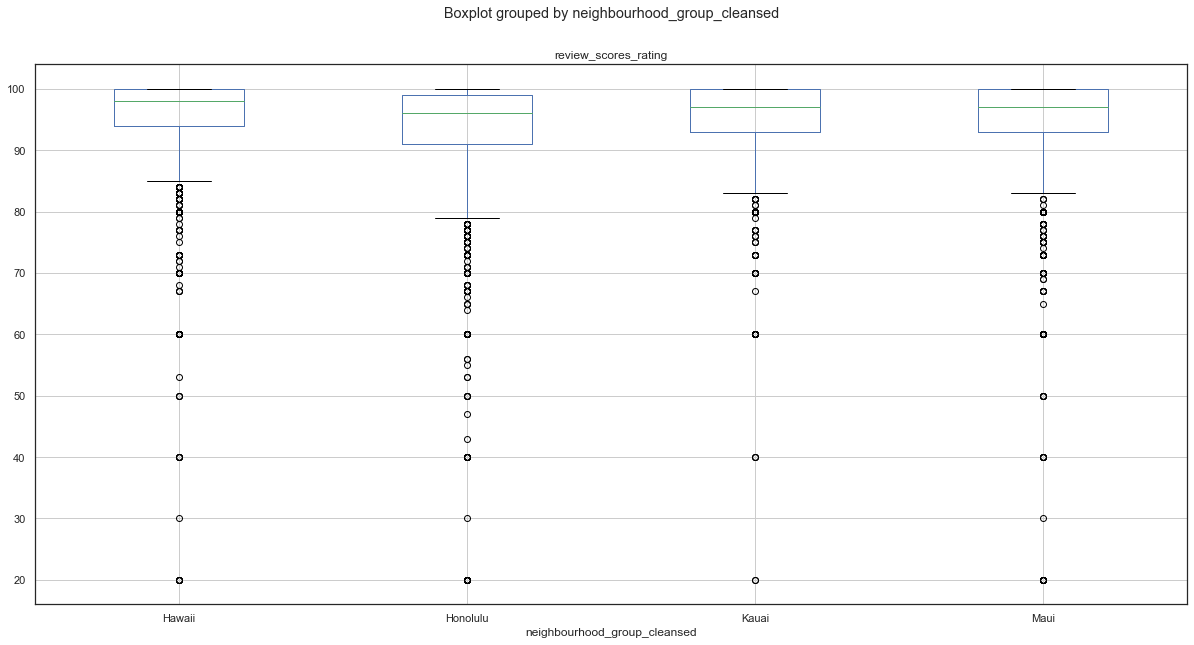

In [67]:
# numerical summary creation of box plot and anova
df.boxplot("review_scores_rating", by="neighbourhood_group_cleansed", figsize=(20, 10))
group1 = df[df["neighbourhood_group_cleansed"] == "Hawaii"]["review_scores_rating"].dropna()
group2 = df[df["neighbourhood_group_cleansed"] == "Maui"]["review_scores_rating"].dropna()
group3 = df[df["neighbourhood_group_cleansed"] == "Kauai"]["review_scores_rating"].dropna()
group4 = df[df["neighbourhood_group_cleansed"] == "Honolulu"]["review_scores_rating"].dropna()

stats.f_oneway(group1, group2, group3, group4)

### P value is less than 0.05 and therefore statistically significant and can reject our null hypothesis.

Evaluate the relationship between "Type of room" and review scores rating
-------------------------------------------------------------------------------------------------------------

Observations:

In [68]:
# create variables and dataframe for desired data and ability to sort later
average_rating_room = df.groupby("room_type").mean()["review_scores_rating"].sort_values(ascending=False)
sorted_room_df = pd.DataFrame({"Average Rating": average_rating_room})

# reset index to reference column in graph
sorted_room_df = sorted_room_df.reset_index()
sorted_room_df

,room_type,Average Rating
0,Private room,94.951852
1,Entire home/apt,94.737967
2,Hotel room,93.774038
3,Shared room,91.917526


<function matplotlib.pyplot.show(*args, **kw)>

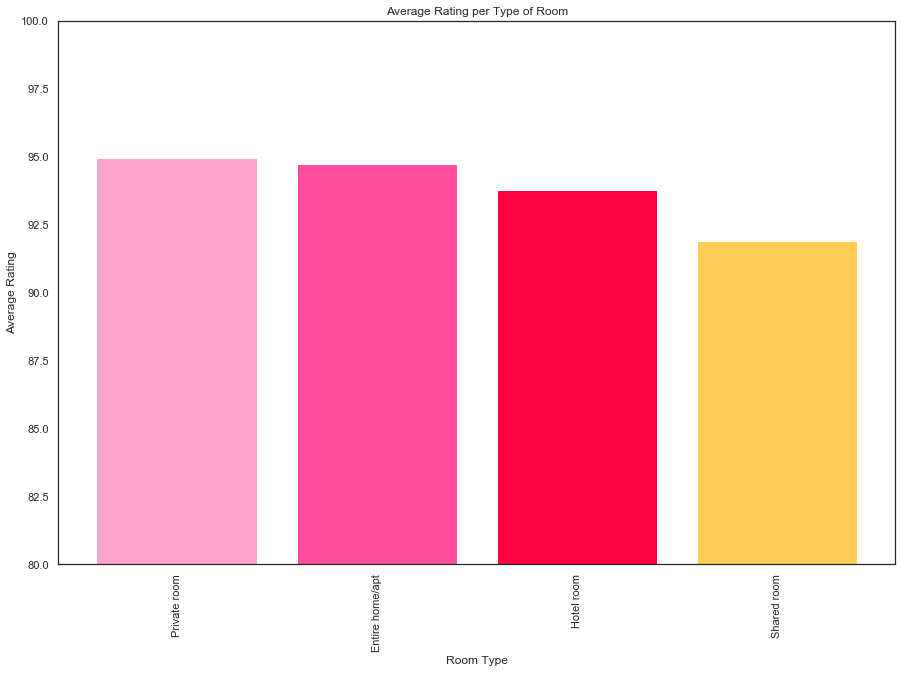

In [69]:
# set x and y axis for bar graph
x_axis = sorted_room_df["room_type"].unique()
y_axis = average_rating_room

# print lables/title and x/y limits to improve visual
plt.subplots(figsize=(15,10))
plt.title("Average Rating per Type of Room")
plt.xlabel("Room Type")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(80, 100)

# display graph
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)
plt.show

### Heat map showing the location of the Airbnb listings based on rating scores.

In [78]:
# create variables to put in heat layer
locations = df[["latitude", "longitude"]]
rating = df['review_scores_value'].astype(float)

# set zoom level and coordinates based on hawaii coordinates
fig = gmaps.figure(center=(20.716179,-157.5828),zoom_level=7)

# create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=rating, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=.02
                                )
# add heat layer
fig.add_layer(heat_layer)

# display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Scatter plot showing Airbnb listings based on availability over a 365 day period.

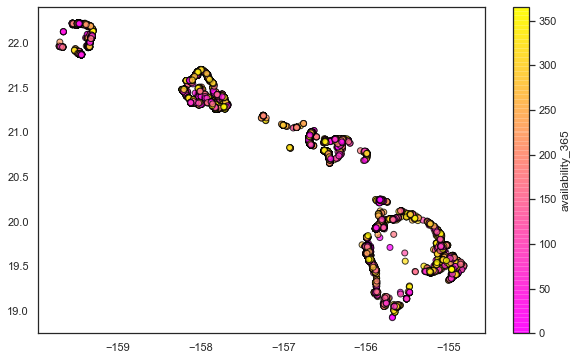

In [79]:
# creat scatter plot based on location and availability over 365 day period
plt.figure(figsize=(10,6))
plt.scatter(df.longitude, df.latitude, c=df.availability_365, cmap='spring', edgecolor='black', linewidth=1, alpha=0.75)

cbar = plt.colorbar()
cbar.set_label('availability_365')

Results:
The number of properties owned by a host does impact the overall rating.
The number of bedrooms does not have an impact on rating.
The neighborhood of the property does have an affect on the rating.
The price of a property does not have a correlation to the rating of the property.
The island that the property is on does appear to have an affect on the average rating.
The island that the property is on does appear to have an affect on the average rating.
There are slightly higher ratings on average for private rooms and entire homes than hotel rooms and shared rooms.